# Disruption type analysis

In [1]:
import json
import numpy as np

import os

"""

This is an example to show the structure of the scenario_folder_{id}.json file.

{
    "scenario_folder_id": "0931",
    "created_at": "2024-12-08T16:22:01.074422Z",
    "data_folder": "../data/Testing/6ac-10-mixed-high/",
    "inputs": {
        "num_scenarios": 10,
        "aircraft_range": [
            6,
            6
        ],
        "amount_aircraft_disrupted": 1,
        "amount_aircraft_uncertain": 1,
        "average_flights_per_aircraft": 12,
        "std_dev_flights_per_aircraft": 1,
        "min_delta_start_unavailability": 120,
        "max_delta_start_unavailability": 480,
        "min_period_unavailability": 120,
        "max_period_unavailability": 480,
        "probability_range": [
            0.5,
            0.9
        ],
        "probability_distribution": "uniform",
        "clear_one_random_aircraft": true,
        "clear_random_flights": true,
        "switch_one_random_flight_to_the_cleared_aircraft": true,
        "first_flight_dep_time_range": [
            6,
            8
        ],
        "flight_length_range": [
            2,
            5
        ],
        "time_between_flights_range": [
            0,
            1
        ]
    },
    "outputs": {
        "Scenario_01": {
            "total_aircraft": 6,
            "total_flights": 15,
            "disrupted_aircraft": 1,
            "disruption_probabilities": {
                "range": [
                    0.5,
                    0.9
                ],
                "distribution": "uniform"
            },
            "aircraft_ids": [
                "A320#1",
                "A320#2",
                "A320#3",
                "A320#4",
                "A320#5",
                "A320#6"
            ],
            "flights_per_aircraft": {
                "A320#1": 3,
                "A320#2": 3,
                "A320#3": 3,
                "A320#4": 0,
                "A320#5": 3,
                "A320#6": 3
            },
            "flights": {
                "1": {
                    "Orig": "MAD",
                    "Dest": "VIE",
                    "DepTime": "08:15",
                    "ArrTime": "11:12",
                    "PrevFlight": 0,
                    "Aircraft": "A320#1"
                },
                "2": {
                    "Orig": "AMS",
                    "Dest": "FRA",
                    "DepTime": "11:58",
                    "ArrTime": "16:01",
                    "PrevFlight": 0,
                    "Aircraft": "A320#1"
                },
                "3": {
                    "Orig": "VIE",
                    "Dest": "ZRH",
                    "DepTime": "16:37",
                    "ArrTime": "20:37",
                    "PrevFlight": 0,
                    "Aircraft": "A320#1"
                },
                "4": {
                    "Orig": "BCN",
                    "Dest": "DUB",
                    "DepTime": "07:15",
                    "ArrTime": "10:57",
                    "PrevFlight": 0,
                    "Aircraft": "A320#2"
                },
                "5": {
                    "Orig": "ORY",
                    "Dest": "LHR",
                    "DepTime": "11:33",
                    "ArrTime": "15:58",
                    "PrevFlight": 0,
                    "Aircraft": "A320#2"
                },
                "6": {
                    "Orig": "LHR",
                    "Dest": "FRA",
                    "DepTime": "16:05",
                    "ArrTime": "19:13",
                    "PrevFlight": 0,
                    "Aircraft": "A320#2"
                },
                "7": {
                    "Orig": "LHR",
                    "Dest": "FRA",
                    "DepTime": "06:00",
                    "ArrTime": "09:31",
                    "PrevFlight": 0,
                    "Aircraft": "A320#3"
                },
                "8": {
                    "Orig": "BCN",
                    "Dest": "DUB",
                    "DepTime": "10:16",
                    "ArrTime": "15:15",
                    "PrevFlight": 0,
                    "Aircraft": "A320#3"
                },
                "9": {
                    "Orig": "BRU",
                    "Dest": "CPH",
                    "DepTime": "15:31",
                    "ArrTime": "20:12",
                    "PrevFlight": 0,
                    "Aircraft": "A320#3"
                },
                "13": {
                    "Orig": "VIE",
                    "Dest": "BCN",
                    "DepTime": "06:30",
                    "ArrTime": "10:40",
                    "PrevFlight": 0,
                    "Aircraft": "A320#5"
                },
                "14": {
                    "Orig": "BCN",
                    "Dest": "ZRH",
                    "DepTime": "11:08",
                    "ArrTime": "15:33",
                    "PrevFlight": 0,
                    "Aircraft": "A320#5"
                },
                "15": {
                    "Orig": "MAD",
                    "Dest": "CPH",
                    "DepTime": "16:03",
                    "ArrTime": "19:37",
                    "PrevFlight": 0,
                    "Aircraft": "A320#5"
                },
                "16": {
                    "Orig": "IST",
                    "Dest": "BRU",
                    "DepTime": "06:30",
                    "ArrTime": "10:23",
                    "PrevFlight": 0,
                    "Aircraft": "A320#6"
                },
                "17": {
                    "Orig": "CDG",
                    "Dest": "DUB",
                    "DepTime": "11:18",
                    "ArrTime": "14:32",
                    "PrevFlight": 0,
                    "Aircraft": "A320#6"
                },
                "18": {
                    "Orig": "LHR",
                    "Dest": "ZRH",
                    "DepTime": "15:13",
                    "ArrTime": "19:53",
                    "PrevFlight": 0,
                    "Aircraft": "A320#6"
                }
            },
            "disruptions": {
                "total_aircraft": 6,
                "disrupted_count": 1,
                "uncertain_count": 1,
                "probability_range": [
                    0.5,
                    0.9
                ],
                "disruptions": [
                    {
                        "aircraft_id": "A320#6",
                        "is_disrupted": true,
                        "is_uncertain": false,
                        "start_date": "28/09/24",
                        "start_time": "12:26",
                        "end_date": "28/09/24",
                        "end_time": "15:27",
                        "probability": 1.0,
                        "delta_start_minutes": 446,
                        "unavailability_period_minutes": 181,
                        "crosses_midnight": false
                    },
                    {
                        "aircraft_id": "A320#5",
                        "is_disrupted": false,
                        "is_uncertain": true,
                        "start_date": "28/09/24",
                        "start_time": "11:04",
                        "end_date": "28/09/24",
                        "end_time": "14:42",
                        "probability": 0.7740562744442862,
                        "delta_start_minutes": 364,
                        "unavailability_period_minutes": 218,
                        "crosses_midnight": false
                    }
                ]
            }
        },
        "Scenario_02": {
            "total_aircraft": 6,
            "total_flights": 15,
            "disrupted_aircraft": 1,
            "disruption_probabilities": {
                "range": [
                    0.5,
                    0.9
                ],
                "distribution": "uniform"
            },
            "aircraft_ids": [
                "A320#1",
                "A320#2",
                "A320#3",
                "A320#4",
                "A320#5",
                "A320#6"
            ],
            "flights_per_aircraft": {
                "A320#1": 3,
                "A320#2": 3,
                "A320#3": 0,
                "A320#4": 3,
                "A320#5": 3,
                "A320#6": 3
            },
            "flights": {
                "1": {
                    "Orig": "MUC",
                    "Dest": "MAD",
                    "DepTime": "06:30",
                    "ArrTime": "09:44",
                    "PrevFlight": 0,
                    "Aircraft": "A320#1"
                },
                "2": {
                    "Orig": "CDG",
                    "Dest": "IST",
                    "DepTime": "10:01",
                    "ArrTime": "13:55",
                    "PrevFlight": 0,
                    "Aircraft": "A320#1"
                },
                "3": {
                    "Orig": "MAD",
                    "Dest": "MUC",
                    "DepTime": "14:54",
                    "ArrTime": "18:25",
                    "PrevFlight": 0,
                    "Aircraft": "A320#1"
                },
                "4": {
                    "Orig": "ZRH",
                    "Dest": "IST",
                    "DepTime": "06:15",
                    "ArrTime": "08:26",
                    "PrevFlight": 0,
                    "Aircraft": "A320#2"
                },
                "5": {
                    "Orig": "MUC",
                    "Dest": "BRU",
                    "DepTime": "09:13",
                    "ArrTime": "12:56",
                    "PrevFlight": 0,
                    "Aircraft": "A320#2"
                },
                "6": {
                    "Orig": "BRU",
                    "Dest": "CDG",
                    "DepTime": "13:54",
                    "ArrTime": "18:34",
                    "PrevFlight": 0,
                    "Aircraft": "A320#2"
                },
                "9": {
                    "Orig": "TXL",
                    "Dest": "BCN",
                    "DepTime": "07:15",
                    "ArrTime": "09:25",
                    "PrevFlight": 0,
                    "Aircraft": "A320#4"
                },
                "10": {
                    "Orig": "ZRH",
                    "Dest": "ORY",
                    "DepTime": "10:24",
                    "ArrTime": "14:27",
                    "PrevFlight": 0,
                    "Aircraft": "A320#4"
                },
                "11": {
                    "Orig": "LHR",
                    "Dest": "AMS",
                    "DepTime": "15:03",
                    "ArrTime": "19:29",
                    "PrevFlight": 0,
                    "Aircraft": "A320#4"
                },
                "12": {
                    "Orig": "TXL",
                    "Dest": "ORY",
                    "DepTime": "06:15",
                    "ArrTime": "08:59",
                    "PrevFlight": 0,
                    "Aircraft": "A320#5"
                },
                "13": {
                    "Orig": "BCN",
                    "Dest": "MAD",
                    "DepTime": "09:17",
                    "ArrTime": "11:54",
                    "PrevFlight": 0,
                    "Aircraft": "A320#5"
                },
                "14": {
                    "Orig": "BRU",
                    "Dest": "ZRH",
                    "DepTime": "12:23",
                    "ArrTime": "16:54",
                    "PrevFlight": 0,
                    "Aircraft": "A320#5"
                },
                "15": {
                    "Orig": "ORY",
                    "Dest": "AMS",
                    "DepTime": "07:45",
                    "ArrTime": "09:54",
                    "PrevFlight": 0,
                    "Aircraft": "A320#6"
                },
                "16": {
                    "Orig": "IST",
                    "Dest": "ORY",
                    "DepTime": "10:09",
                    "ArrTime": "14:48",
                    "PrevFlight": 0,
                    "Aircraft": "A320#6"
                },
                "17": {
                    "Orig": "CPH",
                    "Dest": "BRU",
                    "DepTime": "15:32",
                    "ArrTime": "18:39",
                    "PrevFlight": 0,
                    "Aircraft": "A320#6"
                }
            },
            "disruptions": {
                "total_aircraft": 6,
                "disrupted_count": 1,
                "uncertain_count": 1,
                "probability_range": [
                    0.5,
                    0.9
                ],
                "disruptions": [
                    {
                        "aircraft_id": "A320#3",
                        "is_disrupted": true,
                        "is_uncertain": false,
                        "start_date": "05/09/24",
                        "start_time": "08:39",
                        "end_date": "05/09/24",
                        "end_time": "15:01",
                        "probability": 1.0,
                        "delta_start_minutes": 219,
                        "unavailability_period_minutes": 382,
                        "crosses_midnight": false
                    },
                    {
                        "aircraft_id": "A320#6",
                        "is_disrupted": false,
                        "is_uncertain": true,
                        "start_date": "05/09/24",
                        "start_time": "09:48",
                        "end_date": "05/09/24",
                        "end_time": "17:45",
                        "probability": 0.7859599588591317,
                        "delta_start_minutes": 288,
                        "unavailability_period_minutes": 477,
                        "crosses_midnight": false
                    }
                ]
            }
        },
        "Scenario_03": {
            "total_aircraft": 6,
            "total_flights": 15,
            "disrupted_aircraft": 1,
            "disruption_probabilities": {
                "range": [
                    0.5,
                    0.9
                ],
                "distribution": "uniform"
            },
            "aircraft_ids": [
                "A320#1",

"""





# ../data/Training/6ac-100-deterministic-na/ 0853

# ../data/Training/6ac-100-stochastic-low/  0865
# ../data/Training/6ac-100-stochastic-medium/ 0861
# ../data/Training/6ac-100-stochastic-high/  0857


# ../data/Training/6ac-100-mixed-low/  0870
# ../data/Training/6ac-100-mixed-medium/ 0874
# ../data/Training/6ac-100-mixed-high/  0878


# Automatically get the latest scenario folder
scenario_folder_path = "../logs/scenarios/"
latest_folder = max([f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")], key=lambda x: int(x.split('_')[-1].replace('.json', '')))

latest_folder = "scenario_folder_0878.json"

file_path = os.path.join(scenario_folder_path, latest_folder)

# extract the id from the file path
id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {id}")



# Load the JSON data from the file
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']

# Initialize a dictionary to store the results
results = {}

# Initialize lists to store all probability values
all_probabilities = []

# Extract the data_folder from the file which is just called "data_folder" as key in the json
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")


Scenario ID: 0878
Data Folder: ../data/Training/6ac-100-mixed-high/


Scenario ID: 0878
Data Folder: ../data/Training/6ac-100-mixed-high/
        Scenario  SlackMetric
0    Scenario_01     0.632069
1    Scenario_02     0.652997
2    Scenario_03     0.656704
3    Scenario_04     0.661082
4    Scenario_05     0.667101
..           ...          ...
95   Scenario_96     0.680108
96   Scenario_97     0.695678
97   Scenario_98     0.653436
98   Scenario_99     0.633962
99  Scenario_100     0.630699

[100 rows x 2 columns]


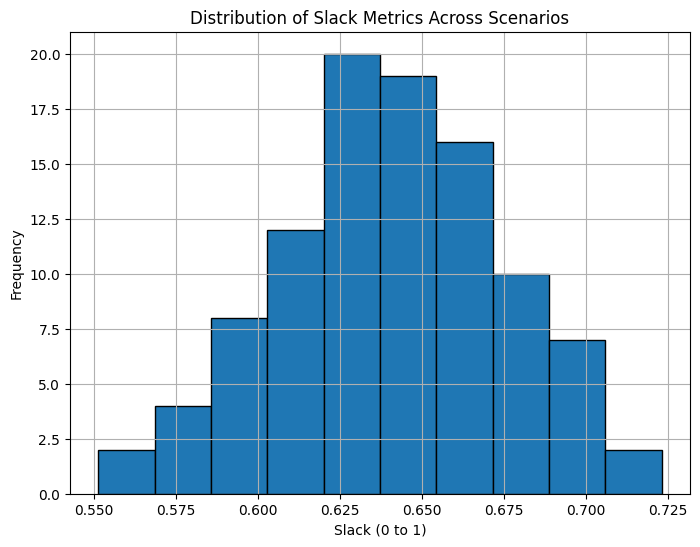

Slack metrics saved to ../logs/scenarios/scenario_slack_metrics_0878.csv


In [2]:
# %%
import pandas as pd
import matplotlib.pyplot as plt


# latest_folder = "scenario_folder_0858.json"

file_path = os.path.join(scenario_folder_path, latest_folder)

# extract the id from the file path
id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {id}")



# Load the JSON data from the file
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']

print(f"Data Folder: {data_folder}")
# %%
import pandas as pd
import matplotlib.pyplot as plt

def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario, defined as the fraction of the 
    total scenario horizon that an aircraft spends in flight.
    Slack_ac = (Total flight time of aircraft ac) / H

    If an aircraft has no flights, its slack = 0.
    """
    flights = scenario_data['flights']
    aircraft_ids = scenario_data['aircraft_ids']

    # If there are no flights at all, horizon is 0; define slack as 0 in this edge case
    if len(flights) == 0:
        return 0.0

    # Identify the overall scenario horizon
    dep_times = [time_to_minutes(f_data['DepTime']) for f_data in flights.values()]
    arr_times = [time_to_minutes(f_data['ArrTime']) for f_data in flights.values()]
    earliest_dep = min(dep_times)
    latest_arr = max(arr_times)
    horizon = latest_arr - earliest_dep if latest_arr > earliest_dep else 1  # prevent division by zero

    # Organize flights by aircraft
    aircraft_flights = {ac: [] for ac in aircraft_ids}
    for f_data in flights.values():
        dep = time_to_minutes(f_data['DepTime'])
        arr = time_to_minutes(f_data['ArrTime'])
        aircraft_flights[f_data['Aircraft']].append((dep, arr))

    # Calculate slack per aircraft
    aircraft_slacks = []
    for ac, f_list in aircraft_flights.items():
        if len(f_list) == 0:
            # No flights: slack = 0
            ac_slack = 0.0
        else:
            total_flight_time = sum(arr - dep for dep, arr in f_list)
            ac_slack = total_flight_time / horizon
        aircraft_slacks.append(ac_slack)

    # Scenario slack is average of all aircraft slacks
    scenario_slack = sum(aircraft_slacks)/len(aircraft_slacks) if aircraft_slacks else 0.0
    return scenario_slack

# Example computation for all scenarios
slack_results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack = calculate_slack_for_scenario(scenario_data)
    slack_results.append({"Scenario": scenario_name, "SlackMetric": scenario_slack})

slack_df = pd.DataFrame(slack_results)
print(slack_df)

# Plot the distribution of slack across scenarios
plt.figure(figsize=(8,6))
plt.hist(slack_df['SlackMetric'], bins=10, edgecolor='black')
plt.title("Distribution of Slack Metrics Across Scenarios")
plt.xlabel("Slack (0 to 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Save results
output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{id}.csv")
slack_df.to_csv(output_file, index=False)
print(f"Slack metrics saved to {output_file}")

